In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import os
import re
import json

In [2]:
# function that gets all notebooks with a given config

def get_df(bitlen, seclvl, mtalg, client_ip, server_ip, min_bandwidth, max_bandwidth, ignore_bandwidth = False):
    names = []
    dicts = process_files_in_directory('../log/', 0, 26, 50)
    for k in dicts:
        # print(f"DEBUG: extracting config from {k}")
        s = ''.join(dicts[k])[50:]
        d = json.loads(s)
        # skip logs before different bit lengths were introduced
        if 'bit_length' not in d['misc']:
            continue
        if d['client']['ip_address'] == client_ip and d['server']['ip_address'] == server_ip:
            if d['misc']['security_level'] == seclvl and d['misc']['mt_algorithm'] == mtalg and d['misc']['bit_length'] == bitlen:
                # print(f"Found file that has appropriate config: {k}")
                bandwidth = extract_bandwidth_from_log_file(f'../log/{k}')
                # print(f'{bandwidth=}')
                if bandwidth:
                    if float(bandwidth) > min_bandwidth and float(bandwidth) < max_bandwidth:
                        names.append(k[6:-4])
                elif ignore_bandwidth:
                    # no bandwidth info
                    names.append(k[6:-4])
    files_to_remove = []
    for file_name in names:
        if not os.path.exists(f'../dfs/{file_name}.csv'):
            # File doesn't exist, add it to the list for removal
            # print(f"df for {file_name} does not exist!")
            files_to_remove.append(file_name)
    
    # Remove the files that don't exist from the original list
    for file_name in files_to_remove:
        names.remove(file_name)
    return pd.concat((pd.read_csv(f"../dfs/{df_name}.csv") for df_name in names), ignore_index=True).reset_index(drop=True)

def read_lines(file_path, start_line, end_line):
    with open(file_path, 'r') as file:
        lines = file.readlines()
        lines = lines[start_line:end_line]
    return lines
def read_until_info(file_path):
    out = []
    with open(file_path, 'r') as file:
        x = file.readline()
        while not 'INFO'in x:
            out.append(x)
            x = file.readline()
    return out
def process_files_in_directory(directory_path, n, m, k):
    result_dict = {}

    # Iterate over files in the directory
    for filename in os.listdir(directory_path):
        file_path = os.path.join(directory_path, filename)

        # Check if it's a file (not a directory)
        if os.path.isfile(file_path):
            # Check if the file has more than N rows
            with open(file_path, 'r') as file:
                line_count = sum(1 for _ in file)

            if line_count > k:
                # Read lines n to m from the file
                lines = read_until_info(file_path)

                # Store the lines in a JSON dictionary
                result_dict[filename] = lines

    return result_dict
def remove_chars_after_last_bracket(input_string):
    last_bracket_index = input_string.rfind('}')
    
    if last_bracket_index != -1:
        return input_string[:last_bracket_index + 1]
    else:
        # If there are no closing curly brackets, return the original string
        return input_string
    
def extract_bandwidth_from_log_file(log_file_path):

    # Open the log file and iterate through its lines
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # Use a regular expression to match the "Bandwidth:" string and the float value
            match = re.search(r"andwidth: (\d+\.\d+) Mbits/sec", line)
            if match:
                bandwidth_str = match.group(1)
                return(float(bandwidth_str))

    return None

def remove_results_between(df, column, a, b):
    return df[(df[column] > a) & (df[column] < b)] 

In [3]:
plt.rcParams['figure.figsize'] = [8, 8]  # default hor./vert. size of plots, in inches

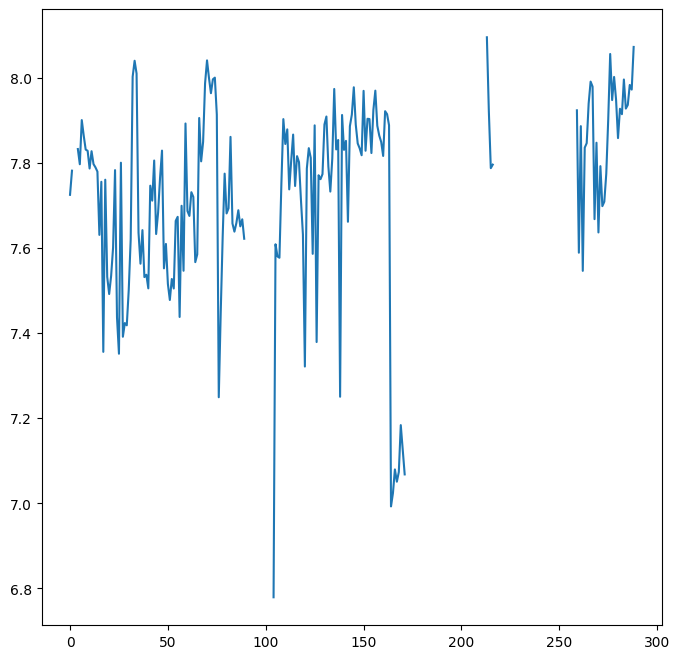

<Axes: >

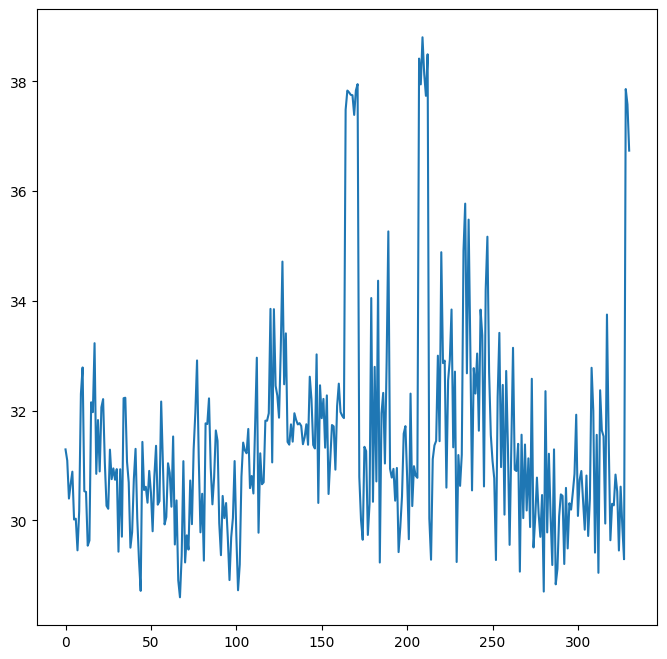

In [4]:
# 80 rpi
df_80_rpi = get_df('32', '80', '0', '192.168.5.115', '192.168.5.114', 60, 80)
# df_80_rpi = remove_results_between(df_80_rpi, 'server.timings.total', 1e4, 36e3)
# df_80_rpi = remove_results_between(df_80_rpi, 'server.hardware.throughput', 7, 8)
df_80_rpi['server.hardware.throughput'].plot()
plt.show()
(df_80_rpi['server.timings.total'] / 1000).plot()

<Axes: >

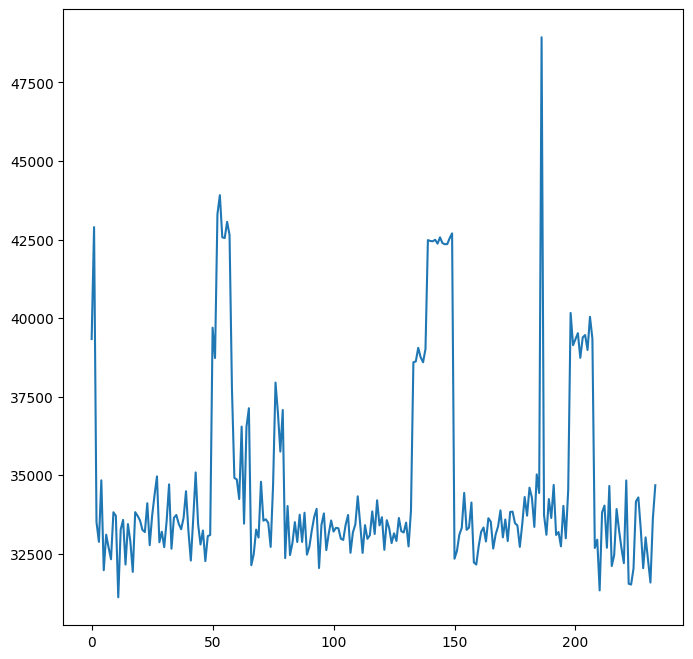

In [5]:
# 112 rpi
df_112_rpi = get_df('32', '112', '0', '192.168.5.115', '192.168.5.114', 60, 80)
# df_80_rpi = remove_results_between(df_80_rpi, 'server.timings.total', 1e4, 36e3)
# df_112_rpi = remove_results_between(df_112_rpi, 'server.hardware.throughput', 7, 8)
# df_112_rpi['server.hardware.throughput'].plot()
plt.show()
df_112_rpi['server.timings.total'].plot()

<Axes: >

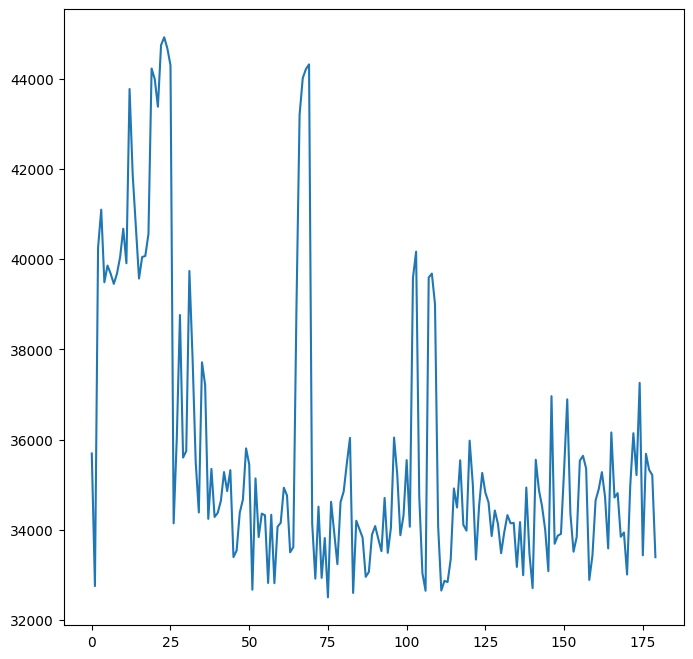

In [6]:
# 128 rpi
df_128_rpi = get_df('32', '128', '0', '192.168.5.115', '192.168.5.114', 60, 80)
# df_128_rpi = remove_results_between(df_128_rpi, 'server.timings.total', 1e4, 45e3)
# df_128_rpi = remove_results_between(df_128_rpi, 'server.hardware.throughput', 7, 8)
# df_128_rpi['server.hardware.throughput'].plot()
plt.show()
df_128_rpi['server.timings.total'].plot()

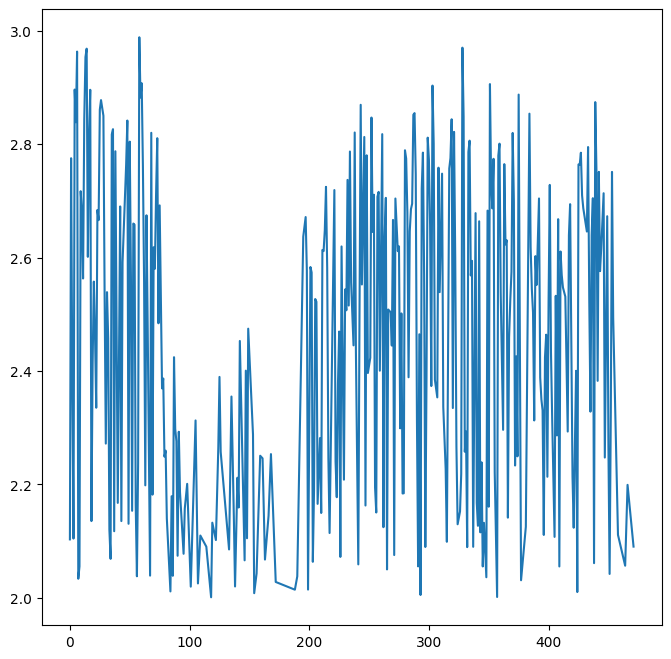

<Axes: >

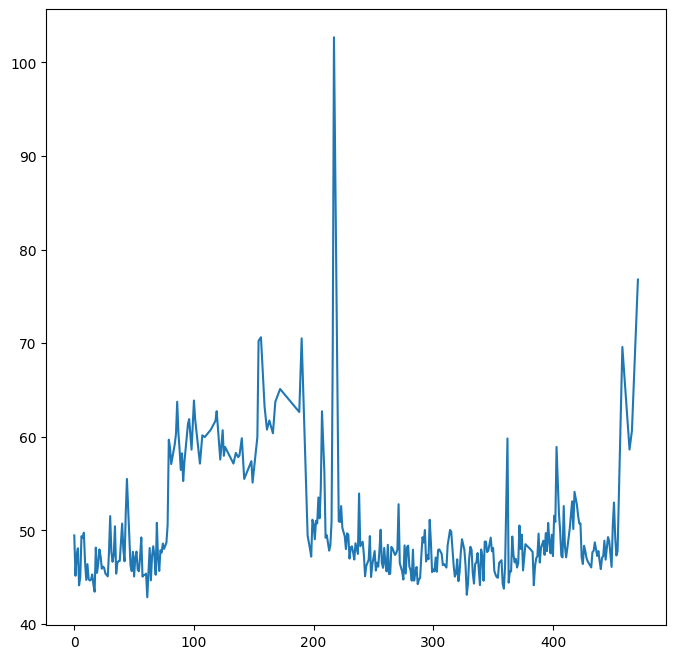

In [7]:
# 80 laptop
df_80_lap = get_df('32', '80', '0', '192.168.5.111', '192.168.5.112', 1, 30)
df_80_lap = remove_results_between(df_80_lap, 'server.hardware.throughput', 2, 3)
df_80_lap = remove_results_between(df_80_lap, 'server.timings.total', 0, 700_000)
df_80_lap['server.hardware.throughput'].plot()
plt.show()
(df_80_lap['server.timings.total'] / 1000).plot()

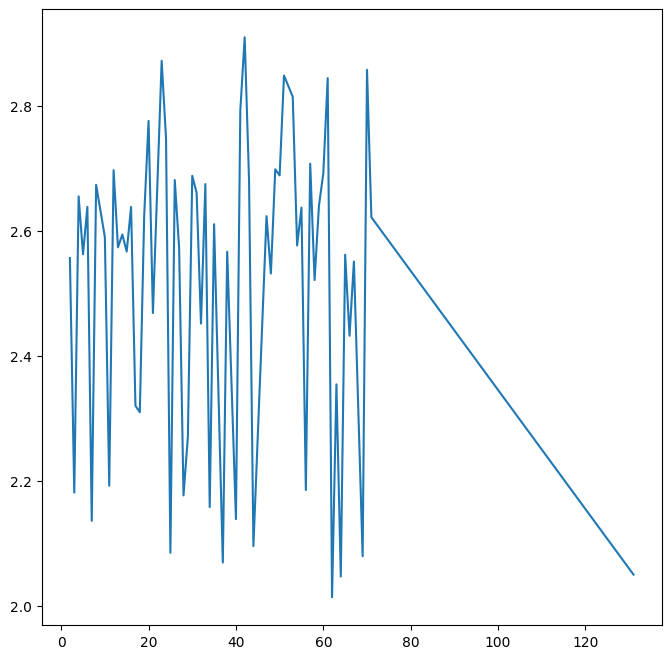

<Axes: >

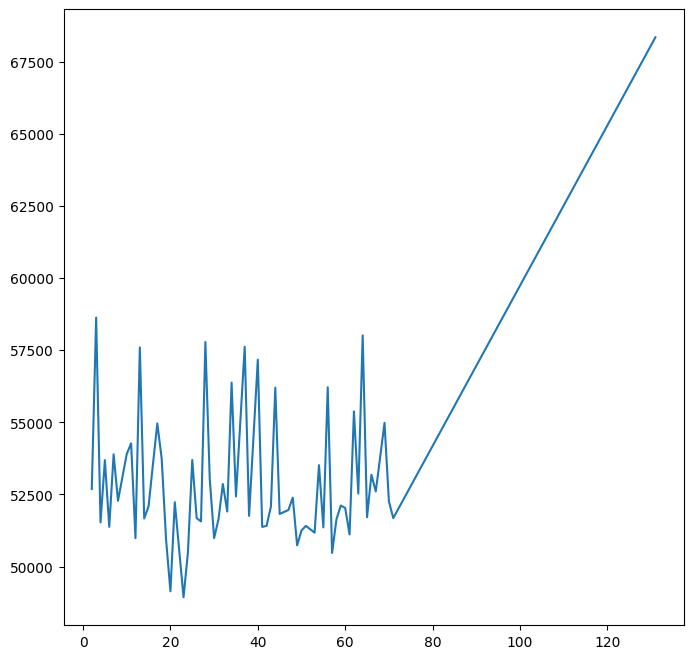

In [8]:
# 112 laptop
df_112_lap = get_df('32', '112', '0', '192.168.5.111', '192.168.5.112', 1, 30)
#df_112_lap = remove_results_between(df_112_lap, 'server.timings.total', 0, 300_000)
df_112_lap = remove_results_between(df_112_lap, 'server.hardware.throughput', 2, 3)
df_112_lap['server.hardware.throughput'].plot()
plt.show()
df_112_lap['server.timings.total'].plot()

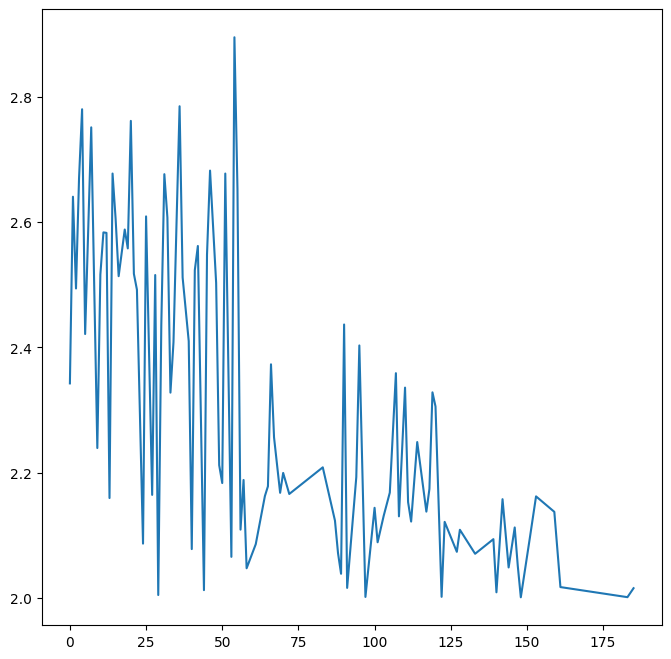

<Axes: >

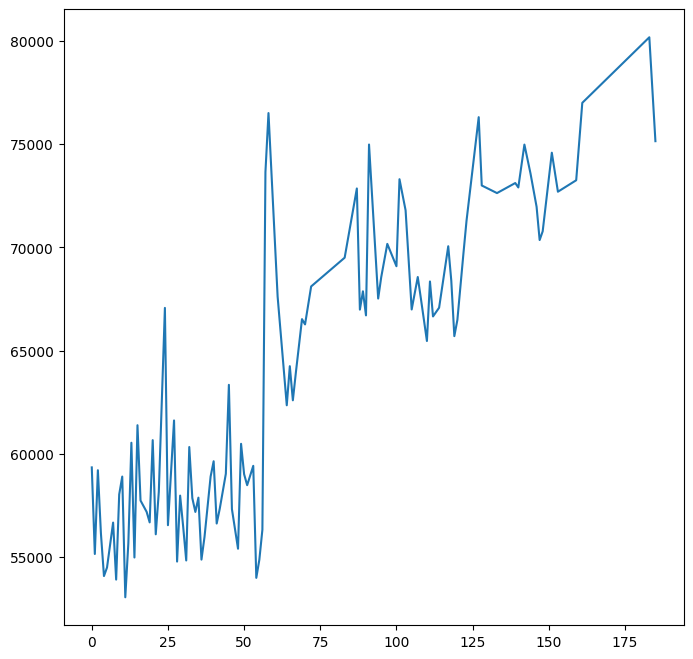

In [9]:
# 128 laptop
df_128_lap = get_df('32', '128', '0', '192.168.5.111', '192.168.5.112', 1, 30)
# df_128_lap = remove_results_between(df_128_lap, 'server.timings.total', 0, 100e3)
df_128_lap = remove_results_between(df_128_lap, 'server.hardware.throughput', 2, 3)
df_128_lap['server.hardware.throughput'].plot()
plt.show()
df_128_lap['server.timings.total'].plot()

Text(0.5, 1.0, 'Security level: speed comparison')

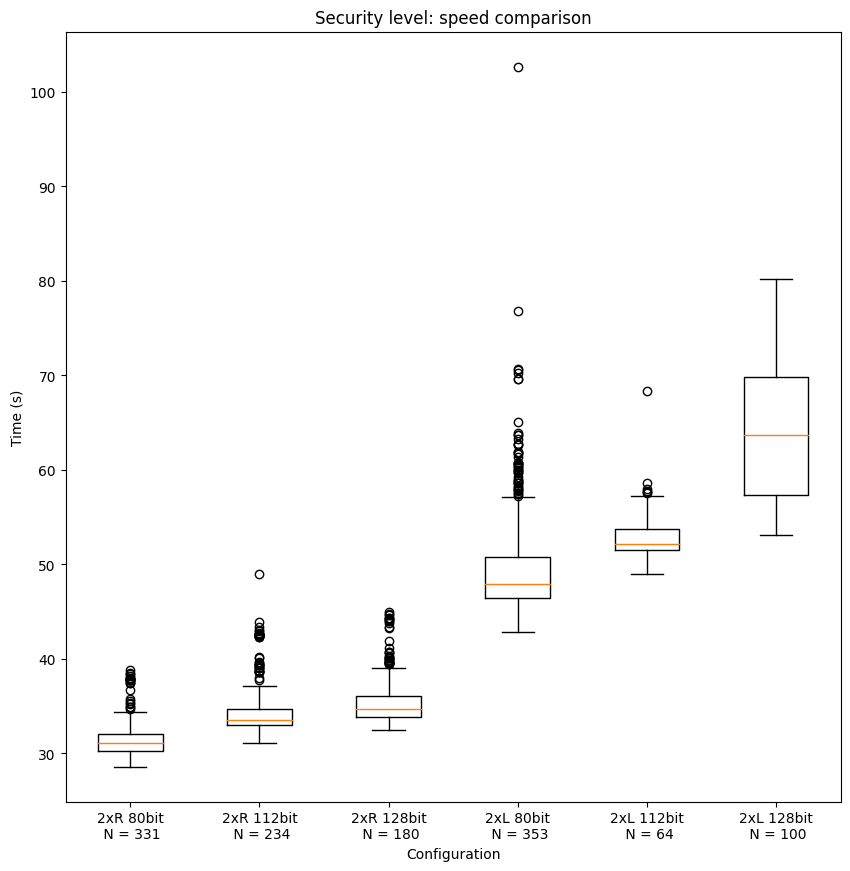

In [10]:
# plotting
df_list = [df_80_rpi, df_112_rpi, df_128_rpi, df_80_lap, df_112_lap, df_128_lap]
plt.rcParams['figure.figsize'] = [10, 10]  # default hor./vert. size of plots, in inches
labels = ["2xR 80bit", "2xR 112bit", "2xR 128bit", "2xL 80bit", "2xL 112bit", "2xL 128bit"]
for i in range(len(labels)):
    labels[i] += "\n N = " + str(len(df_list[i]))
ax = plt.boxplot([df['server.timings.total'] /1000 for df in df_list], labels=labels)
plt.xlabel("Configuration")
plt.ylabel("Time (s)")
plt.title("Security level: speed comparison")